### Introduction
The data for this assignment contains patient reviews on a wide range of drugs within the data from the UCI Machine Learning data repository. The data contains review text, their relevant condition and the outcome of their review in the form of a rating 1-10, with 10 being the most positive. The reviews were submitted by users (patients) of the drugs. Reviews and ratings are grouped into reports on the three aspects: benefits, side effects and overall comment.
#### Objective
The high level objectives in this report is to:
* Perform a Exploratory Data Analysis (EDA) on all the data
* Perform feature engineering on the data set
* Train classification models using the training data
* Test the best models and compare the results to the literature
* Perform a model diagnostics to gain further insights
* Draw conclusions and discuss


In [546]:
#setup
import urllib
import zipfile
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
def seed_everything(seed=1234):
    """"
    Seed everything.
    
    https://datascience.stackexchange.com/questions/66345/why-ml-model-produces-different-results-despite-random-state-defined-and-how-to
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

### Read in the data

In [547]:
zip_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00461/drugLib_raw.zip'
zip_path, _ = urllib.request.urlretrieve(zip_url)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('../data')

In [548]:
train_data=pd.read_csv('../data/drugLibTrain_raw.tsv',sep='\t')
df = train_data
len(df.index)

3107

In [549]:
test_data=pd.read_csv('../data/drugLibTest_raw.tsv',sep='\t')
len(test_data)

1036

In [550]:
data = pd.concat([df, test_data])
data.drop(columns=['Unnamed: 0']).head(10)

urlDrugName  rating           effectiveness  \
0         enalapril       4        Highly Effective   
1  ortho-tri-cyclen       1        Highly Effective   
2           ponstel      10        Highly Effective   
3          prilosec       3    Marginally Effective   
4            lyrica       2    Marginally Effective   
5          propecia       1             Ineffective   
6           vyvanse       9        Highly Effective   
7            elavil      10  Considerably Effective   
8             xanax      10        Highly Effective   
9          claritin       1             Ineffective   

                     sideEffects                               condition  \
0              Mild Side Effects  management of congestive heart failure   
1            Severe Side Effects                        birth prevention   
2                No Side Effects                        menstrual cramps   
3              Mild Side Effects                             acid reflux   
4            Severe Side Effects                            fibromyalgia   
5            Severe Side Effects                               hair loss   
6              Mild Side Effects                                     add   
7                No Side Effects                              depression   
8                No Side Effects                          panic disorder   
9  Extremely Severe Side Effects                               allergies   

                                      benefitsReview  \
0  slowed the progression of left ventricular dys...   
1  Although this type of birth control has more c...   
2  I was used to having cramps so badly that they...   
3  The acid reflux went away for a few months aft...   
4  I think that the Lyrica was starting to help w...   
5  after taking propecia for over a year, startin...   
6  My mood has noticably improved, I have more en...   
7  Although this drug was originally prescribed f...   
8  This simply just works fast and without any of...   
9  none - did nothing to help allergies. i just h...   

                                   sideEffectsReview  \
0  cough, hypotension , proteinuria, impotence , ...   
1  Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...   
2         Heavier bleeding and clotting than normal.   
3  Constipation, dry mouth and some mild dizzines...   
4  I felt extremely drugged and dopey.  Could not...   
5  Low sex drive, before i started taking this dr...   
6  a few experiences of nausiea, heavy moodswings...   
7                                              None.   
8  I really don't have any side effects other tha...   
9  I had some horrifying mental and physical side...   

                                      commentsReview  
0  monitor blood pressure , weight and asses for ...  
1  I Hate This Birth Control, I Would Not Suggest...  
2  I took 2 pills at the onset of my menstrual cr...  
3  I was given Prilosec prescription at a dose of...  
4                                          See above  
5                                one pill once daily  
6  I had began taking 20mg of Vyvanse for three m...  
7     One a day, taken about an hour before bedtime.  
8  I first started taking this at 3 times per day...  
9                       took one 10 mg pill nightly.

### Data Quality

In [551]:
#data quality
import sidetable
missing_df = data.stb.missing()
missing_df[missing_df['missing']>0]

missing  total   percent
commentsReview           8   4143  0.193097
sideEffectsReview        2   4143  0.048274
condition                1   4143  0.024137

In [552]:
data.dropna(inplace=True)
missing_df = data.stb.missing()
missing_df[missing_df['missing']>0]

Empty DataFrame
Columns: [missing, total, percent]
Index: []

### EDA

<AxesSubplot:>

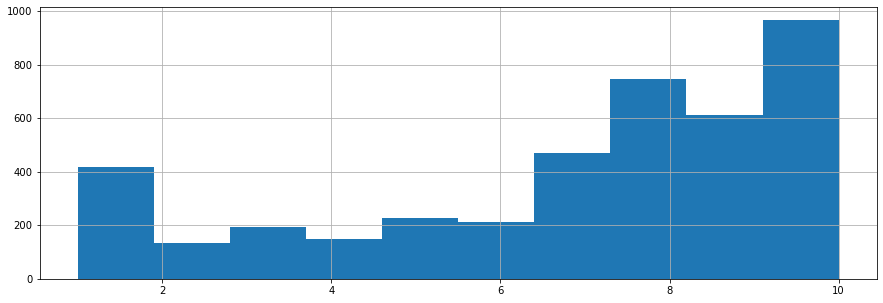

In [553]:
data.rating.hist(figsize=(15,5))

In [554]:
data.rating.describe()

count    4132.000000
mean        6.949661
std         2.948256
min         1.000000
25%         5.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: rating, dtype: float64

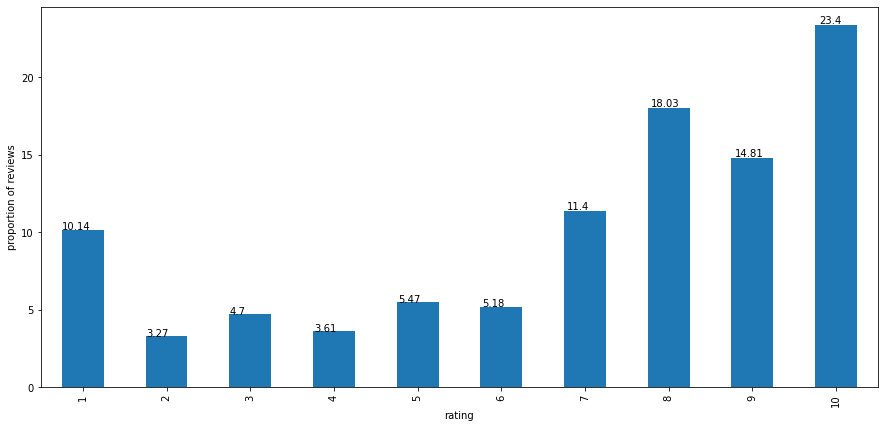

In [555]:
key=[i for i in range(1,11)]
df_count=(data.rating.value_counts().divide(len(data.index))*100).sort_index()
ax=df_count.plot.bar(figsize=(15,7))
ax.set_xlabel("rating")
ax.set_ylabel("proportion of reviews")
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

<AxesSubplot:>

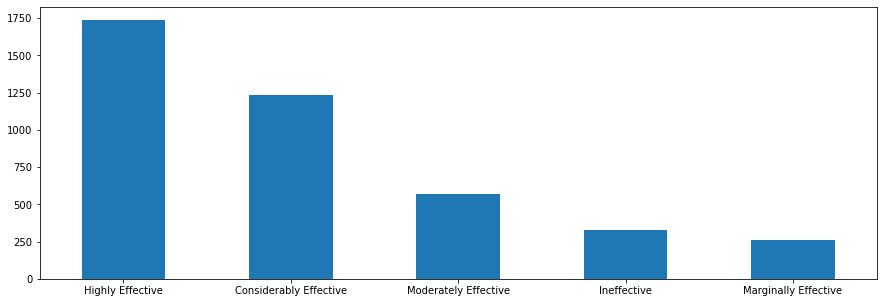

In [556]:
data.effectiveness.value_counts().plot.bar(figsize=(15,5),rot=0)

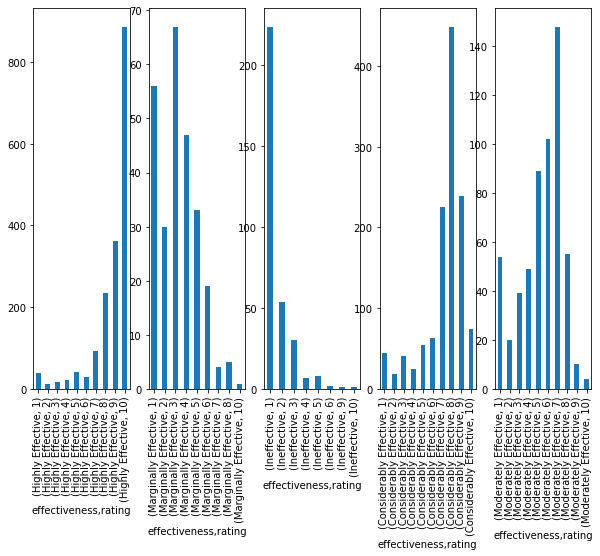

In [557]:
t = plt.subplots(ncols=len(data.effectiveness.unique()))
ax_list = list(t[1])
plt.rcParams['figure.figsize'] = [10, 8]
for i,effectivness in enumerate(data.effectiveness.unique()):
    pdata=data[data['effectiveness']==effectivness][['effectiveness','rating']].groupby(['effectiveness','rating']).size()#.plot.bar(figsize=(15,10))
    pdata.plot.bar(ax=ax_list[i])

<AxesSubplot:>

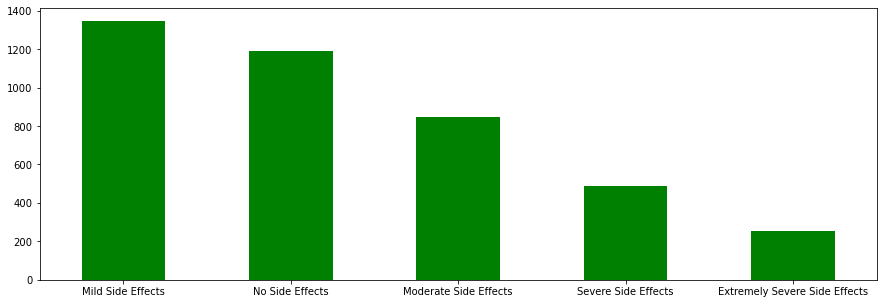

In [558]:
data.sideEffects.value_counts().plot.bar(figsize=(15,5),rot=0,color='green')

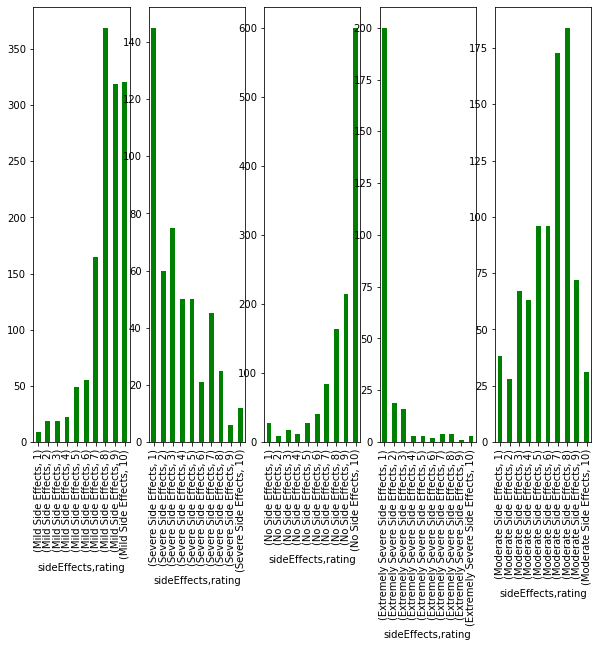

In [559]:
t = plt.subplots(ncols=len(data.sideEffects.unique()))
ax_list = list(t[1])
plt.rcParams['figure.figsize'] = [20, 5]
for i,effectivness in enumerate(data.sideEffects.unique()):
    pdata=data[data['sideEffects']==effectivness][['sideEffects','rating']].groupby(['sideEffects','rating']).size()#.plot.bar(figsize=(15,10))
    pdata.plot.bar(ax=ax_list[i],color='green')

### Correlation Plot

In [560]:
side_effects_map = {'No Side Effects':1,
                    'Mild Side Effects':2, 
                    'Moderate Side Effects':3,
                    'Severe Side Effects':4, 
                    'Extremely Severe Side Effects':5,}
effectiveness_map = {'Highly Effective':5, 
                     'Considerably Effective':4, 
                     'Moderately Effective':3,
                     'Marginally Effective':2, 
                     'Ineffective':1,}

In [561]:
data['sideEffects_numeric']=data.sideEffects.map({
                                'No Side Effects':1,
                                'Mild Side Effects':2, 
                                'Moderate Side Effects':3,
                                'Severe Side Effects':4, 
                                'Extremely Severe Side Effects':5,})
data['effectiveness_numeric']=data.effectiveness.map(
                                        {
                                            'Highly Effective':5, 
                                            'Considerably Effective':4, 
                                            'Moderately Effective':3,
                                            'Marginally Effective':2, 
                                            'Ineffective':1,
                                        }
                                        )


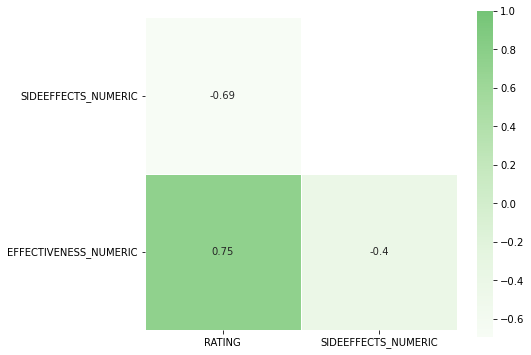

In [562]:
#sn.set_theme(style="white")
import seaborn as sns
corr = data[['rating','sideEffects_numeric','effectiveness_numeric']].astype('int').corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 12))

# adjust mask and df
mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1,mask=mask,cmap="Greens", center=1,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
plt.show()

### Drug names

In [563]:
len(data.urlDrugName.unique())

540

<AxesSubplot:>

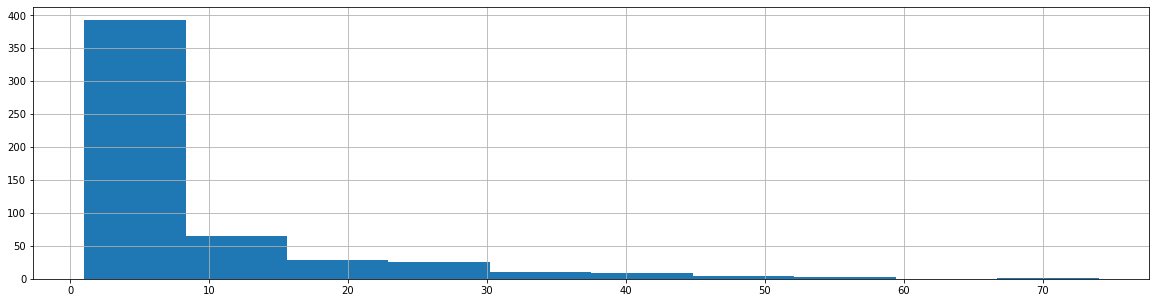

In [564]:
data.urlDrugName.value_counts().hist()#.sort.plot.bar()

In [565]:
data.urlDrugName.value_counts().describe()

count    540.000000
mean       7.651852
std       10.629757
min        1.000000
25%        1.000000
50%        3.000000
75%       10.000000
max       74.000000
Name: urlDrugName, dtype: float64

In [566]:
df=data[['rating','urlDrugName']].groupby('urlDrugName').mean().sort_values(by='rating',ascending=False)
df[df['rating']==10]

rating
urlDrugName                       
nasacort-aq                   10.0
delestrogen                   10.0
exelon                        10.0
neoprofen                     10.0
qvar                          10.0
androgel                      10.0
eulexin                       10.0
prograf                       10.0
vigamox                       10.0
progesterone                  10.0
estratest                     10.0
estrasorb                     10.0
dextrostat                    10.0
erythra-derm                  10.0
baraclude                     10.0
nordette                      10.0
noritate                      10.0
olux                          10.0
pravachol                     10.0
atripla                       10.0
polymyxin-b                   10.0
dyazide                       10.0
avapro                        10.0
piroxicam                     10.0
azopt                         10.0
triphasil                     10.0
axert                         10.0
nasarel                       10.0
phendimetrazine               10.0
buprenorphine                 10.0
sanctura-xr                   10.0
ribavirin                     10.0
bystolic                      10.0
indocin                       10.0
hytrin                        10.0
lidocaine                     10.0
hydrocortisone                10.0
taclonex                      10.0
naltrexone                    10.0
suboxone                      10.0
haldol                        10.0
tekturna                      10.0
zestoretic                    10.0
metformin-extended-release    10.0
geodon                        10.0
methylphenidate               10.0
fosamax-plus-d                10.0
follistim                     10.0
reclipsen                     10.0
flovent                       10.0
bisoprolol                    10.0
flecainide                    10.0
cataflam                      10.0

In [567]:
df=data[['rating','urlDrugName']].groupby('urlDrugName').mean().sort_values(by='rating',ascending=False)
df[df['rating']==1]

rating
urlDrugName                 
compazine                1.0
actiq                    1.0
lodine                   1.0
sustiva                  1.0
accolate                 1.0
metoclopramide           1.0
capoten                  1.0
bactrim-ds               1.0
penlac                   1.0
tylenol-with-codeine     1.0
tequin                   1.0
vistaril                 1.0
aralen                   1.0
diltiazem                1.0
enablex                  1.0
ceclor                   1.0
tekturna-hct             1.0

<AxesSubplot:>

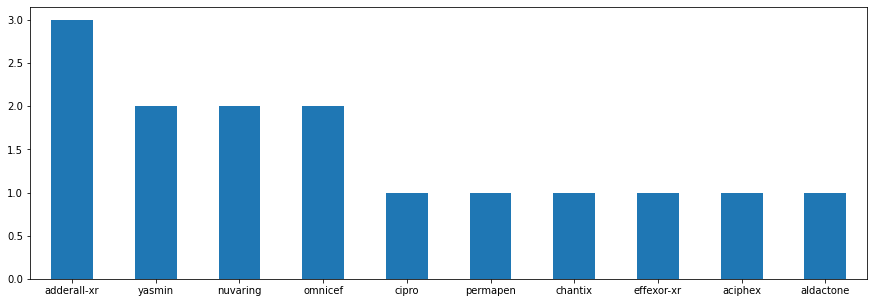

In [568]:
data[
    (data.effectiveness=='Highly Effective') & (data.sideEffects=='Extremely Severe Side Effects')
].urlDrugName.value_counts().head(10).plot.bar(figsize=(15, 5),rot=0,)

<AxesSubplot:>

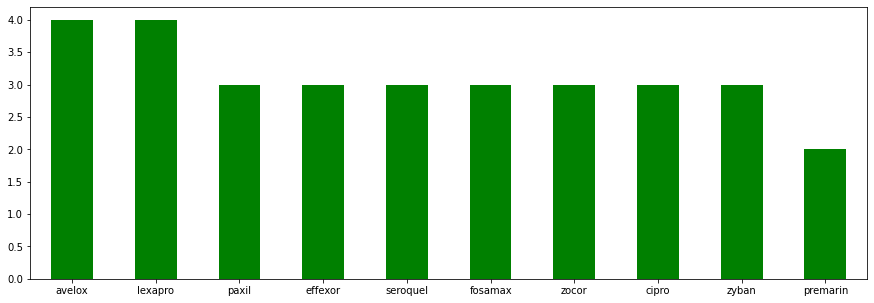

In [569]:
data[(data.effectiveness=='Ineffective') & (data.sideEffects=='Extremely Severe Side Effects')].urlDrugName.value_counts().head(10).plot.bar(figsize=(15, 5),color='Green',rot=0,)

In [570]:
data[(data.effectiveness=='Highly Effective') & (data.sideEffects=='No Side Effects')].urlDrugName.unique()

array(['ponstel', 'xanax', 'effexor-xr', 'symbicort', 'doxycycline',
       'levitra', 'lamictal', 'ortho-tri-cyclen', 'prevacid', 'crestor',
       'metformin', 'synthroid', 'minocycline', 'zantac', 'imitrex',
       'prempro', 'femring', 'nasonex', 'serzone', 'protonix', 'diazepam',
       'provigil', 'zestoretic', 'spiriva', 'allegra', 'vivelle-dot',
       'lamisil', 'wellbutrin-sr', 'yasmin', 'mirapex', 'ambien', 'zmax',
       'renova', 'cymbalta', 'voltaren', 'tetracycline', 'valtrex',
       'cipro', 'relpax', 'climara', 'restasis', 'levoxyl',
       'buprenorphine', 'cytomel', 'premarin', 'grifulvin-v', 'triphasil',
       'naproxen', 'tylenol', 'lunesta', 'tambocor', 'lipitor',
       'armour-thyroid', 'valium', 'citalopram', 'chantix', 'proscar',
       'prednisone', 'flonase', 'azopt', 'selegiline', 'wellbutrin',
       'remeron', 'enbrel', 'ativan', 'macrobid', 'fioricet', 'albuterol',
       'singulair', 'trimethoprim', 'baraclude', 'eulexin', 'prinivil',
       'propecia

#### Conditions

In [571]:
len(data.condition.unique())

1804

<AxesSubplot:>

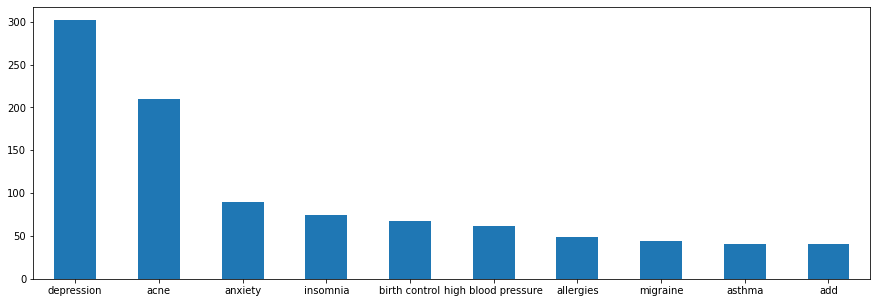

In [572]:
data.condition.value_counts().head(10).plot.bar(figsize=(15, 5),rot=0,)

<AxesSubplot:>

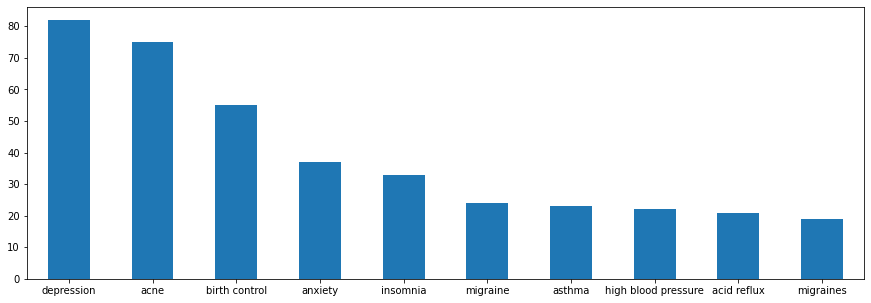

In [573]:
data[(data.effectiveness=='Highly Effective')].condition.value_counts().head(10).plot.bar(figsize=(15, 5),rot=0,)

<AxesSubplot:>

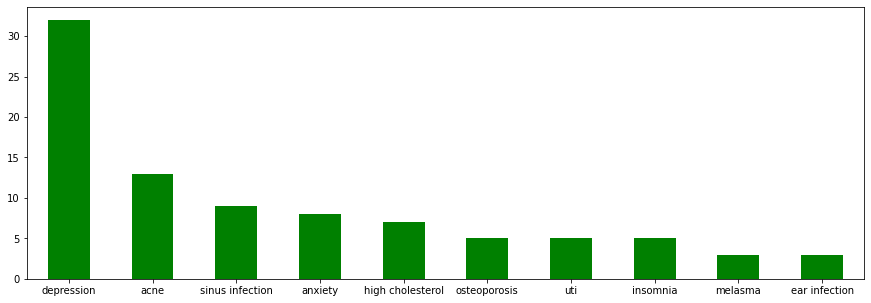

In [574]:
data[(data.effectiveness=='Ineffective')].condition.value_counts().head(10).plot.bar(figsize=(15, 5),color='Green',rot=0,)

<AxesSubplot:>

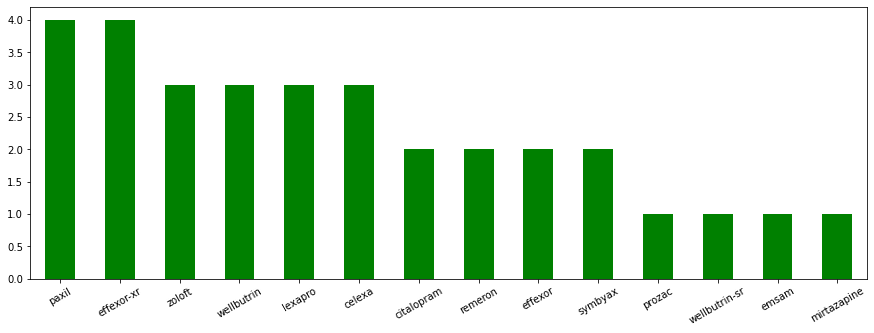

In [575]:
df = data[data['condition']=='depression']
df[(df.effectiveness=='Ineffective')].urlDrugName.value_counts().plot.bar(figsize=(15, 5),color='Green',rot=30,)

<AxesSubplot:>

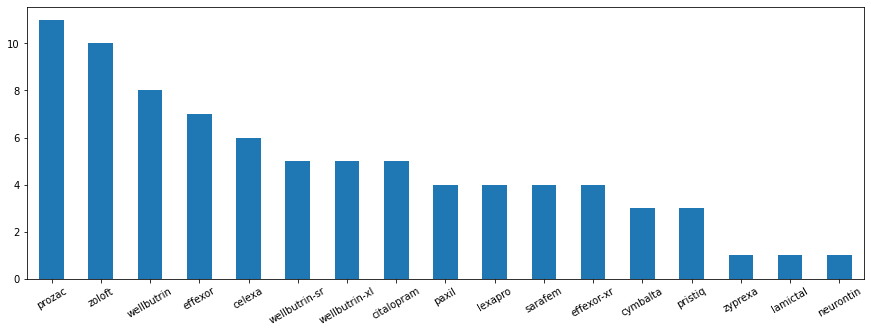

In [576]:
df = data[data['condition']=='depression']
df[(df.effectiveness=='Highly Effective')].urlDrugName.value_counts().plot.bar(figsize=(15, 5),rot=30,)

In [577]:
pos_df=data[data['rating']>6]
neg_df=data[data['rating']<3]

In [578]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
stopwords = set(STOPWORDS)

def generate_cloud(df,word_col):
    wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 800, height = 600).generate(str(df[word_col]))
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

Positive Clouds

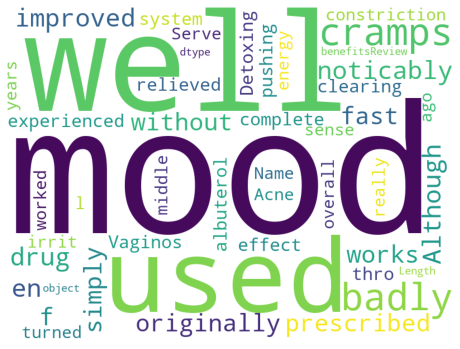

In [579]:
generate_cloud(pos_df,'benefitsReview')

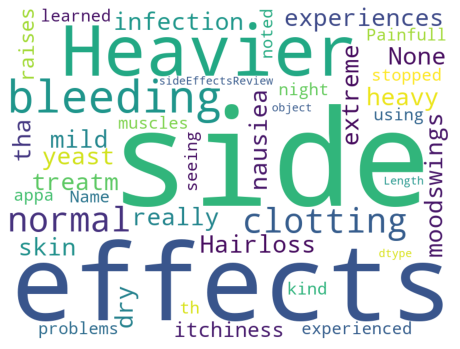

In [580]:
generate_cloud(pos_df,'sideEffectsReview')

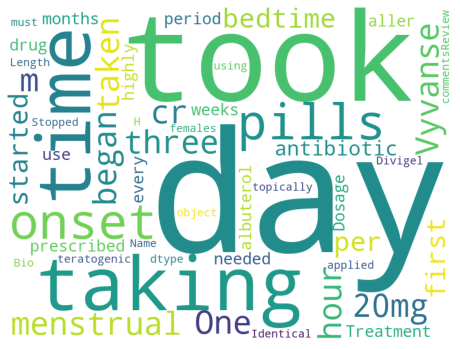

In [581]:
generate_cloud(pos_df,'commentsReview')

Negative Clouds

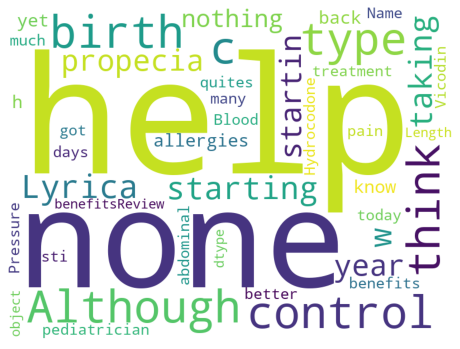

In [582]:
generate_cloud(neg_df,'benefitsReview')

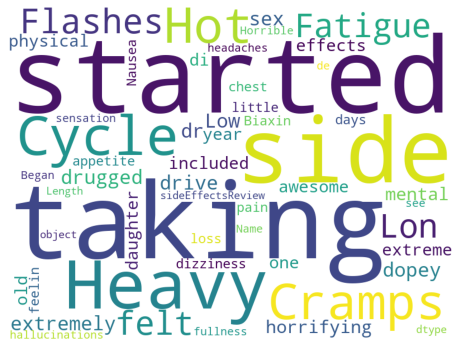

In [583]:
generate_cloud(neg_df,'sideEffectsReview')

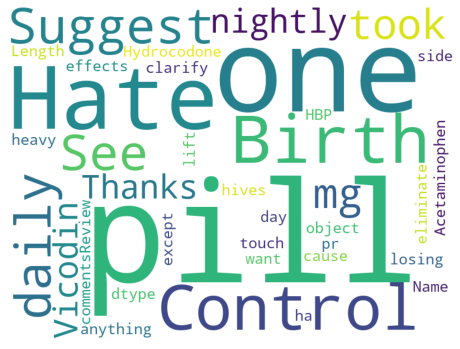

In [584]:
generate_cloud(neg_df,'commentsReview')

### Feature Engineering
Target variable:

In [585]:
data.loc[(data['rating'] >= 6), 'target'] = 1
data.loc[(data['rating'] <6), 'target'] = 0
data['target'].value_counts()

1.0    3009
0.0    1123
Name: target, dtype: int64

Data Cleansing

In [586]:
def review_clean(review): 
    lower = review.str.lower()
    pattern_remove = lower.str.replace("&#039;", "")
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ') 
    return dataframe

In [587]:
data['benefitsReview_cln'] = review_clean(data['benefitsReview'])
data['sideEffectsReview_cln'] = review_clean(data['sideEffectsReview'])
data['commentsReview_cln'] = review_clean(data['commentsReview'])

In [588]:
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

# Removing the stopwords
stop_words = set(stopwords.words('english'))
data['benefitsReview_cln'] = data['benefitsReview_cln'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
data['sideEffectsReview_cln'] = data['sideEffectsReview_cln'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
data['commentsReview_cln'] = data['commentsReview_cln'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [589]:
Snow_ball = SnowballStemmer("english")
data['benefitsReview_cln'] = data['benefitsReview_cln'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))
data['sideEffectsReview_cln'] = data['sideEffectsReview_cln'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))
data['commentsReview_cln'] = data['commentsReview_cln'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))


Sentiment Polarity/Subject Feature

In [590]:
def sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity

def subjectivity(review):
    analysis = TextBlob(review)
    return analysis.sentiment.subjectivity


In [591]:
data['benefitsReview_sen'] = data['benefitsReview'].apply(sentiment)
data['sideEffectsReview_sen'] = data['sideEffectsReview'].apply(sentiment)
data['commentsReview_sen'] = data['commentsReview'].apply(sentiment)

data['benefitsReview_sub'] = data['benefitsReview'].apply(subjectivity)
data['sideEffectsReview_sub'] = data['sideEffectsReview'].apply(subjectivity)
data['commentsReview_sub'] = data['commentsReview'].apply(subjectivity)

### Review Text Feature

In [592]:
#Word count in each review
data['benefitsReview_cnt'] = data['benefitsReview_cln'].apply(lambda x: len(str(x).split()))
data['sideEffectsReview_cnt'] = data['sideEffectsReview_cln'].apply(lambda x: len(str(x).split()))
data['commentsReview_cnt'] = data['commentsReview_cln'].apply(lambda x: len(str(x).split()))
#Unique word count 
data['benefitsReview_uniq_cnt'] = data['benefitsReview_cln'].apply(lambda x: len(set(str(x).split())))
data['sideEffectsReview_uniq_cnt'] = data['sideEffectsReview_cln'].apply(lambda x: len(set(str(x).split())))
data['commentsReview_uniq_cnt'] = data['commentsReview_cln'].apply(lambda x: len(set(str(x).split())))
#Average length of the words
data['benefitsReview_mean_len'] = data['benefitsReview_cln'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data['sideEffectsReview_mean_len'] = data['sideEffectsReview_cln'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data['commentsReview_mean_len'] = data['commentsReview_cln'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


In [593]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
 ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['benefitsReview_cln'].values)
vectorizer.get_feature_names_out()

print(X.shape)

(4132, 6230)


In [594]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [595]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
trsvd = TruncatedSVD(X)

In [596]:
'''
https://analyticsindiamag.com/beginners-guide-to-truncated-svd-for-dimensionality-reduction/
'''
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
def get_models():
    models = dict()
    for i in range(1,200):
        steps = [('vec',TfidfVectorizer()),('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores






### ML

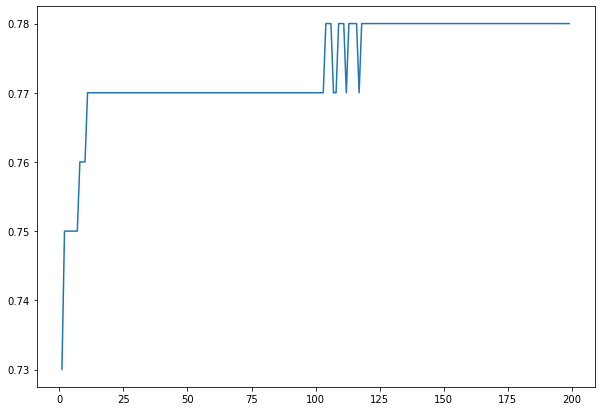

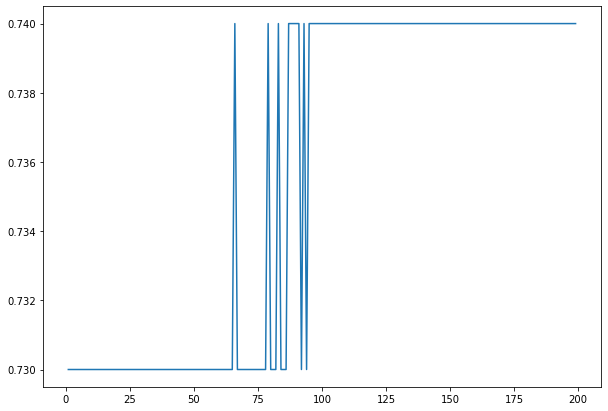

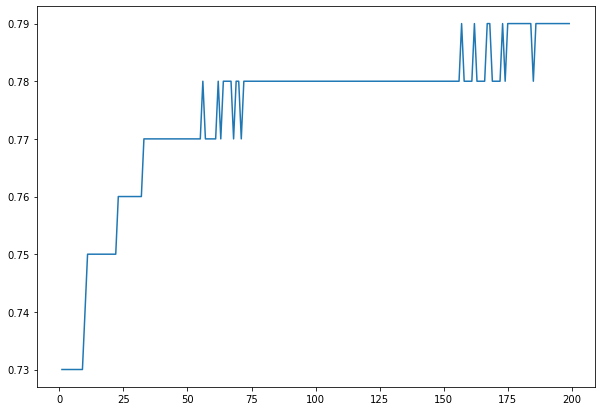

In [597]:
for review in ['benefitsReview_cln','commentsReview_cln','sideEffectsReview_cln']:
    f'plot for {review}'
    x = data[review].values
    y = data['target'].values
    models=get_models()
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, x, y)
        results.append(scores)
        names.append(name)
        #print('>%s %.3f' % (name, np.mean(scores)))

    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(range(1,len(results)+1),[round(np.mean(x),2) for x in results])
    plt.xticks()
    plt.show() 

In [598]:
len(results)

199

In [599]:
data.drop(columns=['Unnamed: 0', 'urlDrugName', 'rating', 
       'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'
       ,'sideEffects_numeric','effectiveness_numeric'  ],inplace=True)

In [600]:
data.dropna(inplace=True)

In [601]:
x = data.drop(columns='target')
y = data['target']

In [602]:
from imblearn.over_sampling import SMOTEN
oversample = SMOTEN()
x, y = oversample.fit_resample(x, y)

In [603]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [636]:
X_train

effectiveness                    sideEffects  \
2248  Considerably Effective              Mild Side Effects   
332              Ineffective            Severe Side Effects   
1918  Considerably Effective              Mild Side Effects   
4977  Considerably Effective            Severe Side Effects   
1856  Considerably Effective              Mild Side Effects   
...                      ...                            ...   
352         Highly Effective              Mild Side Effects   
5797  Considerably Effective  Extremely Severe Side Effects   
3506    Moderately Effective          Moderate Side Effects   
5447             Ineffective            Severe Side Effects   
57      Moderately Effective          Moderate Side Effects   

                                     benefitsReview_cln  \
2248        yes would recommend drug peopl mild depress   
332   appar benefit virtual effect depress quick bec...   
1918  bystol signific lower dyastol systol pressur p...   
4977  cholesterol lower would need larger dose meet ...   
1856  relief symptom interstiti cystiti includ pain ...   
...                                                 ...   
352   addit quick resolv bronchiti asthma improv sig...   
5797  abl curb appetit lose weight effect 1st two we...   
3506  reduc high blood pressur patient receiv good c...   
5447                                               none   
57    skin certain area e g forehead cheek sun damag...   

                                  sideEffectsReview_cln  \
2248  tire work lot hour felt over tire day came med...   
332                           extrem drowsi weight gain   
1918  bystol initi mild insomnia sleepi day symptom ...   
4977  allerg reaction use benzoyl peroxid pore becam...   
1856        initi feel woozi nausea tired wore 6 8 week   
...                                                 ...   
352    bad tast mouth morn easili fix brush vivid dream   
5797  25 time experienc chronic yeast infect drug 10...   
3506  patient experi constip gas occas patient conce...   
5447  blur vision inabl function daili basi 100 grog...   
57    dri skin flaki skin breakout first 6 8 week ir...   

                                     commentsReview_cln  benefitsReview_sen  \
2248  1 pill everi night depress doctor want tri dif...            0.333333   
332   virtual effect depress side effect intoler too...            0.154167   
1918  bystol one tablet bedtim necessari take medic ...            0.000000   
4977  follow derm tomorrow see altern treatment go s...            0.000000   
1856  reliev symptom interstiti cystiti signific 1 y...            0.000000   
...                                                 ...                 ...   
352                   simpli take pill twice day 10 day            0.013889   
5797  pleas dont ever take medic im horrifi made fee...            0.000000   
3506         patient impress drug must taken entir life            0.259444   
5447  began 5 mg increas 10mg week abl increas side ...            0.000000   
57    renova appli nightim approx 20 minut cleans sk...            0.036772   

      sideEffectsReview_sen  commentsReview_sen  benefitsReview_sub  \
2248              -0.450000            0.000000            0.500000   
332               -0.125000            0.000000            0.425000   
1918               0.411111            0.316667            0.000000   
4977               0.000000            0.000000            0.000000   
1856               0.000000            0.104167            0.000000   
...                     ...                 ...                 ...   
352               -0.118750            0.000000            0.388889   
5797              -0.313333            0.000000            0.000000   
3506               0.000000            0.000000            0.607222   
5447               0.000000           -0.012500            0.000000   
57                 0.061111           -0.022222            0.458862   

      sideEffectsReview_sub  commentsR

In [638]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


class Generic_clf(BaseEstimator):
    '''
    A base classifier which will allow any classifier be passed
    to a pipeline
    '''
    def __init__(
        self, 
        estimator = GaussianNB(),
    ):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

review_features=['benefitsReview_cln', 'sideEffectsReview_cln', 'commentsReview_cln']
numeric_features = ['benefitsReview_sen',
       'sideEffectsReview_sen', 'commentsReview_sen', 'benefitsReview_sub',
       'sideEffectsReview_sub', 'commentsReview_sub', 'benefitsReview_cnt',
       'sideEffectsReview_cnt', 'commentsReview_cnt',
       'benefitsReview_uniq_cnt', 'sideEffectsReview_uniq_cnt',
       'commentsReview_uniq_cnt', 'benefitsReview_mean_len',
       'sideEffectsReview_mean_len', 'commentsReview_mean_len']
    
ordinal_features = ['effectiveness', 'sideEffects',]


preprocessor = ColumnTransformer(
    transformers=[
        #('td-idf',TfidfVectorizer(),review_features),
        ('imp',SimpleImputer(),numeric_features),
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ordinal_features)
        
    ]
)


fs = SelectKBest()

pipeline = Pipeline([
      ('preprocessor', preprocessor),
      ('svd', TruncatedSVD(n_components=20)),
      ('fs', fs),
      ('clf', Generic_clf()),
])

parameters = [

    {
        'preprocessor__num__with_mean':[True,False],
        'preprocessor__num__with_std':[True,False],
        'fs__k':['all'],#[50,100,200,'all'],
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [1000],
    },
    
]

gscv = GridSearchCV(pipeline, parameters, cv=5,error_score="raise", return_train_score=False, verbose=3)

In [623]:
gscv

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('td-idf',
                                                                         TfidfVectorizer(),
                                                                         ['benefitsReview_cln',
                                                                          'sideEffectsReview_cln',
                                                                          'commentsReview_cln']),
                                                                        ('imp',
                                                                         SimpleImputer(),
                                                                         ['benefitsReview_sen',
                                                                          'sideEffectsReview_sen',
                                                                          'commentsReview_sen',
                                                                          'benefitsReview_sub',
                                                                          'sideEffectsReview_sub',
                                                                          'comme...
                                                                          'commentsReview_mean_len']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['effectiveness',
                                                                          'sideEffects'])])),
                                       ('fs', SelectKBest()),
                                       ('clf', Generic_clf())]),
             param_grid=[{'clf__estimator': [RandomForestClassifier()],
                          'clf__estimator__n_estimators': [1000],
                          'fs__k': [50, 100, 200, 'all'],
                          'preprocessor__num__with_mean': [True, False],
                          'preprocessor__num__with_std': [True, False]}],
             verbose=3)

In [640]:
res=gscv.fit(X_train.reset_index(),y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__estimator=RandomForestClassifier(), clf__estimator__n_estimators=1000, fs__k=all, preprocessor__num__with_mean=True, preprocessor__num__with_std=True;, score=0.930 total time=  10.3s
[CV 2/5] END clf__estimator=RandomForestClassifier(), clf__estimator__n_estimators=1000, fs__k=all, preprocessor__num__with_mean=True, preprocessor__num__with_std=True;, score=0.909 total time=  10.3s
[CV 3/5] END clf__estimator=RandomForestClassifier(), clf__estimator__n_estimators=1000, fs__k=all, preprocessor__num__with_mean=True, preprocessor__num__with_std=True;, score=0.921 total time=  10.3s
[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__n_estimators=1000, fs__k=all, preprocessor__num__with_mean=True, preprocessor__num__with_std=True;, score=0.905 total time=  11.0s
[CV 5/5] END clf__estimator=RandomForestClassifier(), clf__estimator__n_estimators=1000, fs__k=all, preprocessor__num__with_mean=True, p

In [607]:
y_train

2248    1.0
332     0.0
1918    1.0
4977    0.0
1856    1.0
       ... 
352     1.0
5797    0.0
3506    1.0
5447    0.0
57      1.0
Name: target, Length: 4486, dtype: float64

In [ ]:
df=pd.DataFrame(res.cv_results_)

In [ ]:
df.sort_values(by='mean_test_score',ascending=False).head(20)

In [642]:
res.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imp', SimpleImputer(),
                                                  ['benefitsReview_sen',
                                                   'sideEffectsReview_sen',
                                                   'commentsReview_sen',
                                                   'benefitsReview_sub',
                                                   'sideEffectsReview_sub',
                                                   'commentsReview_sub',
                                                   'benefitsReview_cnt',
                                                   'sideEffectsReview_cnt',
                                                   'commentsReview_cnt',
                                                   'benefitsReview_uniq_cnt',
                                                   'sideEffectsReview_uniq_cnt',
                                                   'comments...
                                                   'sideEffectsReview_uniq_cnt',
                                                   'commentsReview_uniq_cnt',
                                                   'benefitsReview_mean_len',
                                                   'sideEffectsReview_mean_len',
                                                   'commentsReview_mean_len']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['effectiveness',
                                                   'sideEffects'])])),
                ('svd', TruncatedSVD(n_components=20)),
                ('fs', SelectKBest(k='all')),
                ('clf',
                 Generic_clf(estimator=RandomForestClassifier(n_estimators=1000)))])

In [ ]:
'''
 Citation: Class contains code adapted from
 URL: https://stackoverflow.com/questions/39043326/computing-feature-importance-with-onehotencoded-feature
 Permission: MIT Licence Retrieved on:05th January 2023  
'''
pre_model = model.named_steps['preprocessor'] 
classifier = model.named_steps['clf'].estimator 
ct = model.named_steps['preprocessor'] 
feature_names = pre_model.get_feature_names_out()
feature_importance = np.array(classifier.feature_importances_)
data = {'feature_names': feature_names, 'feature_importance': feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

if 'cat' in ct.named_transformers_.keys() and hasattr(ct.named_transformers_['cat'], 'feature_names_in_'):
    original_cat_features = ct.named_transformers_['cat'].feature_names_in_.tolist()
    all_cat_list = ct.named_transformers_['cat'].get_feature_names_out(original_cat_features).tolist()

    # A for loop for original_cat_features to find the one hot encoded features corresponding to each original categorical feature   
    for original_cat_feature in original_cat_features:
        cat_list = [i for i in all_cat_list if i.startswith(original_cat_feature)]
        for i, element in enumerate(cat_list):
            cat_list[i] = 'cat__' + element
        cat_sum = fi_df[fi_df['feature_names'].isin(cat_list)]['feature_importance'].sum()
        fi_df = fi_df[~fi_df['feature_names'].isin(cat_list)]
        temp_dict = {'feature_names': original_cat_feature, 'feature_importance': cat_sum}
        fi_df = fi_df.append(temp_dict, ignore_index=True)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Getting rid of the prefixes of the feature names    
prefixes = ('num__', 'cat__', 'imp__')
for prefix in prefixes:
    fi_df['feature_names'] = fi_df['feature_names'].apply(lambda x: str(x).replace(prefix,""))

fi_df.set_index('feature_names').plot.bar(rot=45,figsize=(12, 7))

In [643]:
res.best_estimator_.score(X_test,y_test)

0.9278074866310161

In [644]:
y_preds = res.best_estimator_.predict(X_test)
y_preds_proba = res.best_estimator_.predict_proba(X_test)
# AUC
auc_rfc = roc_auc_score(y_test, y_preds_proba[:, 1])

In [645]:
auc_rfc

0.9797804009059982

In [ ]:
res.best_estimator_.fit(X_train, y_train)

In [646]:
from sklearn.metrics import accuracy_score
acc_rfc = accuracy_score(y_preds, y_test)
print("AUC: %3.2f" % (auc_rfc))
print("Accuracy: %3.2f" % (acc_rfc))

AUC: 0.98
Accuracy: 0.93


In [ ]:
res.best_estimator_.fit(X_train, y_train)

In [653]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_preds)

0.8556886094797256

In [662]:
x_ohe = OneHotEncoder(handle_unknown="ignore").fit(X_train[['effectiveness','sideEffects']]).transform(X_train[['effectiveness','sideEffects']])

In [666]:
pd.concat(X_train.drop(columns=['effectiveness','sideEffects']),pd.DataFrame(x_ohe.toarray()))

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [667]:
X_train.drop(columns=['effectiveness','sideEffects'])

benefitsReview_cln  \
2248        yes would recommend drug peopl mild depress   
332   appar benefit virtual effect depress quick bec...   
1918  bystol signific lower dyastol systol pressur p...   
4977  cholesterol lower would need larger dose meet ...   
1856  relief symptom interstiti cystiti includ pain ...   
...                                                 ...   
352   addit quick resolv bronchiti asthma improv sig...   
5797  abl curb appetit lose weight effect 1st two we...   
3506  reduc high blood pressur patient receiv good c...   
5447                                               none   
57    skin certain area e g forehead cheek sun damag...   

                                  sideEffectsReview_cln  \
2248  tire work lot hour felt over tire day came med...   
332                           extrem drowsi weight gain   
1918  bystol initi mild insomnia sleepi day symptom ...   
4977  allerg reaction use benzoyl peroxid pore becam...   
1856        initi feel woozi nausea tired wore 6 8 week   
...                                                 ...   
352    bad tast mouth morn easili fix brush vivid dream   
5797  25 time experienc chronic yeast infect drug 10...   
3506  patient experi constip gas occas patient conce...   
5447  blur vision inabl function daili basi 100 grog...   
57    dri skin flaki skin breakout first 6 8 week ir...   

                                     commentsReview_cln  benefitsReview_sen  \
2248  1 pill everi night depress doctor want tri dif...            0.333333   
332   virtual effect depress side effect intoler too...            0.154167   
1918  bystol one tablet bedtim necessari take medic ...            0.000000   
4977  follow derm tomorrow see altern treatment go s...            0.000000   
1856  reliev symptom interstiti cystiti signific 1 y...            0.000000   
...                                                 ...                 ...   
352                   simpli take pill twice day 10 day            0.013889   
5797  pleas dont ever take medic im horrifi made fee...            0.000000   
3506         patient impress drug must taken entir life            0.259444   
5447  began 5 mg increas 10mg week abl increas side ...            0.000000   
57    renova appli nightim approx 20 minut cleans sk...            0.036772   

      sideEffectsReview_sen  commentsReview_sen  benefitsReview_sub  \
2248              -0.450000            0.000000            0.500000   
332               -0.125000            0.000000            0.425000   
1918               0.411111            0.316667            0.000000   
4977               0.000000            0.000000            0.000000   
1856               0.000000            0.104167            0.000000   
...                     ...                 ...                 ...   
352               -0.118750            0.000000            0.388889   
5797              -0.313333            0.000000            0.000000   
3506               0.000000            0.000000            0.607222   
5447               0.000000           -0.012500            0.000000   
57                 0.061111           -0.022222            0.458862   

      sideEffectsReview_sub  commentsReview_sub  benefitsReview_cnt  \
2248               0.700000            0.600000                   7   
332                1.000000            0.000000                   9   
1918               0.666667            0.783333                  21   
4977               0.000000            0.000000                   3   
1856               0.000000            0.604167                   8   
...                     ...                 ...                 ...   
352                0.654167            0.357143                  32   
5797               0.453571            0.000000                   4   
3506               0.000000            0.625000                  22   
5447               0.000000            0.212500                   1   
57                 0.311111         

In [656]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(res.best_estimator_.named_steps['clf'].fit(X_train, y_train), X_test, y_test) 

ValueError: could not convert string to float: 'Considerably Effective'

In [668]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    source : https://stackoverflow.com/questions/57329189/rendering-a-confusion-matrix
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[700  59]
 [ 49 688]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

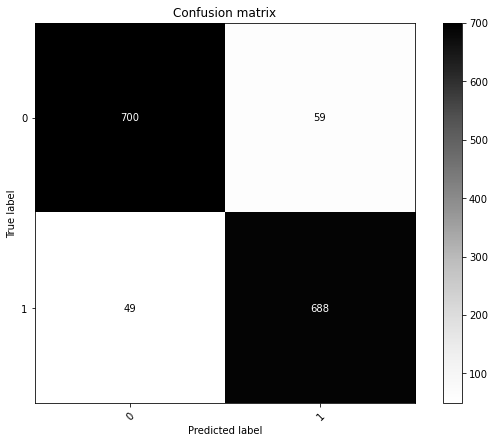

In [669]:
 plot_confusion_matrix(y_test, y_preds, classes=[],normalize= False,  title='Confusion matrix',cmap=plt.cm.Greys) 

Normalized confusion matrix
[[0.92226614 0.07773386]
 [0.06648575 0.93351425]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

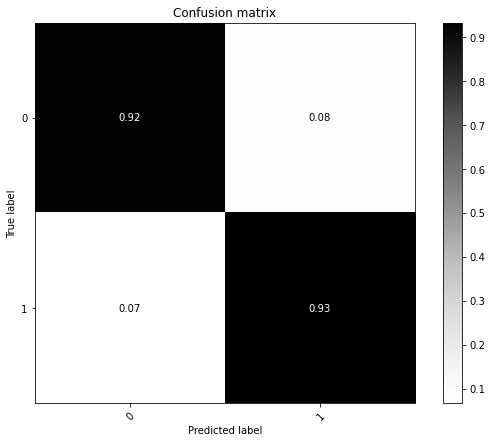

In [670]:
 plot_confusion_matrix(y_test, y_preds, classes=[],normalize= True,  title='Confusion matrix',cmap=plt.cm.Greys)